# A k-Armed Bandit Problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['figure.figsize'] = 12, 4

## Helper functions for bandit generators

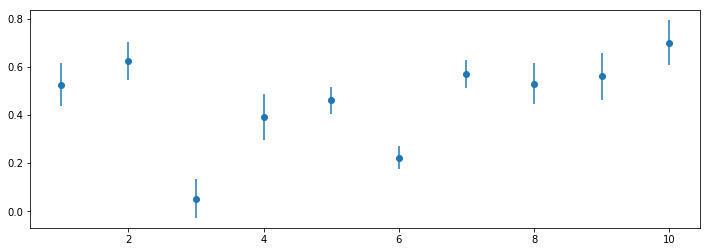

In [2]:
class Bandit:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def roll(self):
        return np.random.normal(self.mean, self.std)
    
    def random_walk(self, step_size=0.1):
        if np.random.rand() > 0.5:
            mean = self.mean+step_size
        else:
            mean = self.mean-step_size
        return Bandit(mean, self.std)


def random_bandits(k, max_mean=1.0, max_std=0.1):
    bs = []
    for _ in range(k):
        mean = np.random.uniform(0.0, max_mean)
        std = np.random.uniform(0.0, max_std)
        bs.append(Bandit(mean, std))
    return bs
    
    
def generate_bandits_list(k, n):    
    """Generate list of k-armed bandits
       Used to create non stationary process
    """
    bandits = random_bandits(k)
    xs = [bandits]
    for i in range(1, n):
        bs = [b.random_walk() for b in xs[i-1]]
        xs.append(bs)
    return xs

    
def plot_bandits(bs):
    x = np.array(np.linspace(1, k, k))
    y = [x.mean for x in bandits]
    e = [x.std for x in bandits]
    plt.errorbar(x, y, e, linestyle='None', marker='o')
    plt.show()    
    
    
def moving_average(xs, n=100):
    cs = np.cumsum(xs, dtype=float)
    cs[n:] = cs[n:] - cs[:-n]
    return cs[n - 1:] / n    


# Sample bandits
k = 10
bandits = random_bandits(k)
plot_bandits(bandits)

## Helper function for agents and learning

In [3]:
class Agent:
    
    def choose_action(self):
        return 0
    
    def learn(self, action, reward):
        pass
    
    
def evaluate_stationary(agent, bandits, num_episodes=1000, window=10):
    """Stationary process. Always use the same bandits"""
    rewards = []
    for episode in range(num_episodes):
        total_reward = 0
        for j in range(100):
            a = agent.choose_action()
            reward = bandits[a].roll()
            agent.learn(a, reward)
            total_reward += reward
        rewards.append(total_reward/100.0)
    return moving_average(rewards, window)


def evaluate(agent, bandits_list, window=10):
    """Non stationary process. Each episode uses different bandits"""
    rewards = []
    for bandits in bandits_list:
        total_reward = 0
        for j in range(100):
            a = agent.choose_action()
            reward = bandits[a].roll()
            agent.learn(a, reward)
            total_reward += reward
        rewards.append(total_reward/100.0)
    return moving_average(rewards, window)

## Random agent

This agent select bandit randomly

In [4]:
class RandomAgent(Agent):
    
    def __init__(self, k):
        self.k = k
        
    def choose_action(self):
        """ Choose which bandit to run. 
        """
        return np.random.choice(range(self.k))
    
    
agent = RandomAgent(k)    
[agent.choose_action() for _ in range(20)]

[8, 4, 3, 7, 8, 2, 3, 9, 3, 1, 2, 7, 2, 0, 8, 2, 5, 6, 4, 2]

## Run random agent

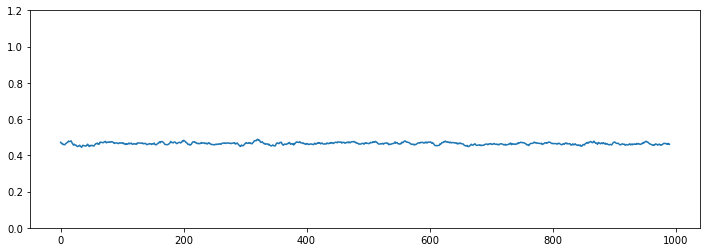

In [5]:
plt.plot(evaluate_stationary(RandomAgent(k), bandits))
plt.ylim([0, 1.2])
plt.show()

## E-Greedy agent

This agent selects, with high probability, bandit which so far got the highest reward and with small probability random bandit.

The probability is a trade off between exploitation and exploration.

In [6]:
class EGreedyAgent(Agent):
    
    def __init__(self, k, epsilon):
        self.k = k
        self.epsilon = epsilon
        self.Q = np.zeros(k)
        self.counters = np.zeros(k)
        
    def choose_action(self):
        """Select random bandit with probability epsilon.
           Or best bandit otherwise
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.k))
        else:
            return np.argmax(self.Q)
        
    def learn(self, action, reward):
        n = self.counters[action]
        self.Q[action] = (self.Q[action]*n + reward)/(n+1)
        self.counters[action] += 1

## Run E-Greedy agent

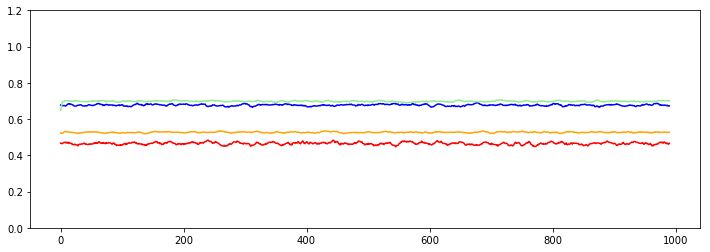

In [7]:
plt.plot(evaluate_stationary(RandomAgent(k), bandits), color='red')
plt.plot(evaluate_stationary(EGreedyAgent(k, 0.0), bandits), color='orange')
plt.plot(evaluate_stationary(EGreedyAgent(k, 0.1), bandits), color='blue')
plt.plot(evaluate_stationary(EGreedyAgent(k, 0.01), bandits), color='lightgreen')
plt.ylim([0, 1.2])
plt.show()

## Learning rate

EGreedyAgent keeps average reward and counter for each action to update action reward.

To make it more efficient we can change update rule:

$$ Q'_{a} = \frac{Q_{a}*(n-1) + r}{n} = Q - \frac{Q_{a}}{n} + \frac{r}{n} = Q + \frac{1}{n}(r-Q_{a}) $$


where:
  * $Q_{a}$ - expected reward for given action (bandit)
  * a - action
  * r - current reward
  * n - counter (how many times this action was selected)
  * $r-Q$  - Error term
  * $\alpha = \frac{1}{n}$ - Learning rate
  
 Update rule:
 
 $$ Q_{a}' = Q_{a} + \alpha(r-Q_{a}) $$

In [8]:
class AlphaAgent:
    
    def __init__(self, k, epsilon, alpha=0.1):
        self.k = k
        self.epsilon = epsilon
        self.alpha = alpha
        self.Q = np.zeros(k)
        
    def choose_action(self):
        """Select random bandit with probability epsilon.
           Or best bandit otherwise
        """
        if np.random.rand() < self.epsilon:
            return np.random.choice(range(self.k))
        else:
            return np.argmax(self.Q)
        
    def learn(self, action, reward):
        self.Q[action] = self.Q[action] + self.alpha*(reward-self.Q[action])


## Lets compare agents

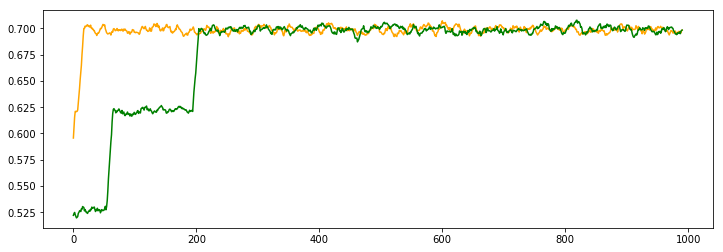

In [9]:
plt.plot(evaluate_stationary(EGreedyAgent(k, 0.01), bandits), color='orange')
plt.plot(evaluate_stationary(AlphaAgent(k, 0.01), bandits), color='green')
plt.show()

For stationary environment our new agents takes a little bit longer to learn but still achive the same score.

Lets compare agents for not stationary envoronment

## Non stationary bandits

In [14]:
# Non stationary process
bandits_list = generate_bandits_list(k, 1000)

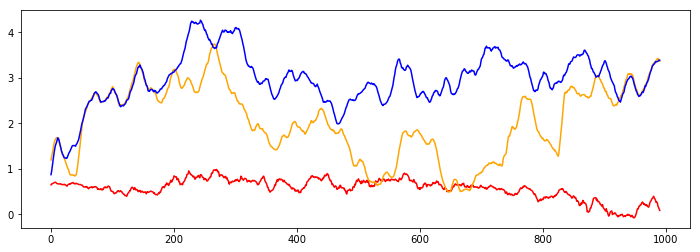

In [15]:
plt.plot(evaluate(RandomAgent(k), bandits_list), color='red')
plt.plot(evaluate(EGreedyAgent(k, 0.1), bandits_list), color='orange')
plt.plot(evaluate(AlphaAgent(k, 0.1), bandits_list), color='blue')
plt.show()

AlphaAgent learns faster since it doesn't average over all seen rolls.
But it highly depend on the underlining process.